## `artemis` - porównanie działania metod model-agnostic 

Benchmark przeprowadzono na popularnym syntetycznym zbiorze danych wykorzystywanym w literaturze dot. interakcji w modelach predykcyjnych.

Dataset jest generowany na podstawie funkcji postaci: 
$$ F(x) = \exp(x_1x_2 + 1) - \exp(x_3+x_4+1) + \cos(x_5+x_6-x_8) + \sqrt{x_8^2+x_9^2+x_{10}^2}.$$

Zmienne $x_1, x_2, x_3, x_6, x_7, x_9$ są rozkładu jednostajnego $U(0, 1)$, a zmienne $x4, x5, x8, x10$ z rozkładu jednostajnego $U(0.6, 1)$. 

Spodziewane interakcje par zmiennych (przy założeniu ***idealnego*** modelu) to: 
- pary zmiennych z pierwszego składnika funkcji: 
    - $(x_1, x_2)$,
- para zmiennych z drugiego składnika funkcji:
    - $(x_3, x_4)$,
- para zmiennych z trzeciego składnika funkcji: 
    - $(x_5, x_6)$,
    - $(x_5, x_8)$,
    - $(x_6, x_8)$,
- pary zmiennych z czwartego składnika funkcji:
    - $(x_8, x_9)$,
    - $(x_8, x_{10})$,
    - $(x_9, x_{10})$,

Należy pamiętać, że generowane wyjaśnienia mają być prawdziwe dla modelu, nie danych - zatem nie wszystkie interakcje muszą być znalezione przez model. 
Natomiast w przypadku tak prostej funkcji najważniejsze interakcje powinny się pokrywać.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod, GreenwellMethod, SejongOhMethod
from artemis.interactions_methods.model_specific import ConditionalMinimalDepthMethod, SplitScoreMethod
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng()
X1_3 = rng.uniform(0, 1, 15000).reshape((5000, 3))
X4_5 = rng.uniform(0.6, 1, 10000).reshape((5000, 2))
X6_7 = rng.uniform(0, 1, 10000).reshape((5000, 2))
X8 =  rng.uniform(0.6, 1, 5000).reshape((5000, 1))
X9 = rng.uniform(0, 1, 5000).reshape((5000, 1))
X10 =  rng.uniform(0.6, 1, 5000).reshape((5000, 1))

In [3]:
X = np.hstack((X1_3, X4_5, X6_7, X8, X9, X10))

In [4]:
def f2(X_org):
    X = np.hstack((np.zeros(5000).reshape((5000, 1)), X_org))
    return (
        np.exp(X[:, 1] * X[:, 2] + 1)
        - np.exp(X[:, 3] - X[:, 4])
        + np.cos(X[:, 5] + X[:, 6] - X[:, 8])
        + np.sqrt(X[:, 8] ** 2 + X[:, 9] ** 2 + X[:, 10] ** 2)
    )


In [5]:
expected_pairs = [
    ("X1", "X2"),
    ("X3", "X4"),
    ("X5", "X6"),
    ("X5", "X8"),
    ("X6", "X8"),
    ("X8", "X9"),
    ("X8", "X10"),
    ("X9", "X10"),
]

### Regresja

In [6]:
y = f2(X)

In [7]:
exp1_data = pd.DataFrame(np.hstack((X, y.reshape(5000, 1))))
exp1_data.columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'y']
X = exp1_data.drop('y', axis=1)
y = exp1_data['y']
X_train, y_train = X.iloc[:4500], y.iloc[:4500]
X_test, y_test = X.iloc[4500:], y.iloc[4500:]

In [8]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, max_features="sqrt").fit(X_train, y_train)

In [9]:
results_path = "../experiments/results/"

### Greenwell Method

In [10]:
import shap
X_test_repr = pd.DataFrame(shap.kmeans(X_test, 50).data, columns = X_test.columns)

d:\iad\eng_thesis\feature-interactions-explanations\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [11]:
vint = GreenwellMethod()
vint.fit(model, X_test_repr, show_progress=True) 

Calculating feature importance: 100%|██████████| 10/10 [00:00<00:00, 20.76it/s]


In [12]:
vint.ovo

,Feature 1,Feature 2,Greenwell Variable Interaction Measure
0,X1,X2,0.299632
1,X2,X9,0.011799
2,X2,X3,0.010973
3,X6,X8,0.010509
4,X1,X3,0.010483
5,X2,X6,0.010336
6,X3,X6,0.008263
7,X1,X6,0.005288
8,X3,X4,0.004626
9,X1,X9,0.004488


In [13]:
vint.ovo.to_csv(results_path + "f2_greenwell.csv")

In [14]:
import pickle

with open(results_path + "f2_vint.pkl", "wb") as f:
    pickle.dump(vint, f)

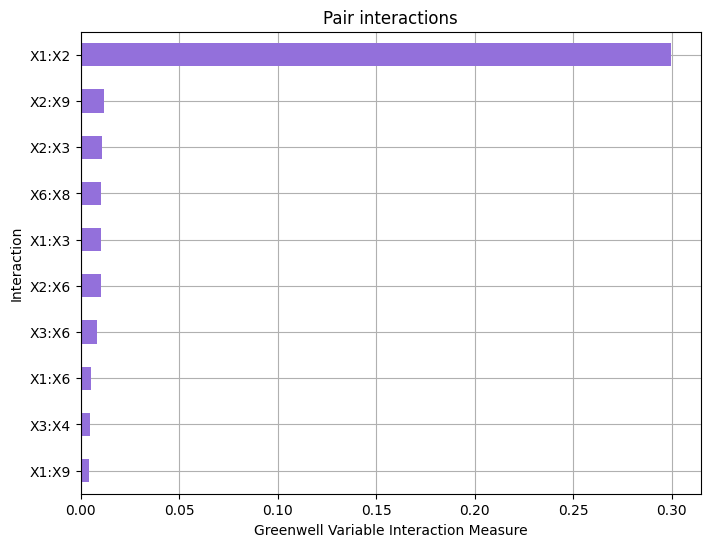

In [15]:
vint.plot("bar_chart", top_k=15, show=True)

Pierwsze 7 par zmiennych to rzeczywiście interakcje w danych. 

In [16]:
ovo = vint.ovo.copy()
exp_mask = ovo.apply(lambda x: (x["Feature 1"], x["Feature 2"]) in expected_pairs, axis=1).cumsum()
res_vint = [exp_mask[2], exp_mask[4], exp_mask[9], exp_mask[19]]
found_vint = [el in list(zip(ovo.loc[:10, "Feature 1"], ovo.loc[:10, "Feature 2"])) for el in expected_pairs]

### H statistic (normalized)

In [17]:
h_stat = FriedmanHStatisticMethod()
h_stat.fit(model, X_test, show_progress=True)

Calculating one vs all interactions: 100%|██████████| 10/10 [00:40<00:00,  4.10s/it]


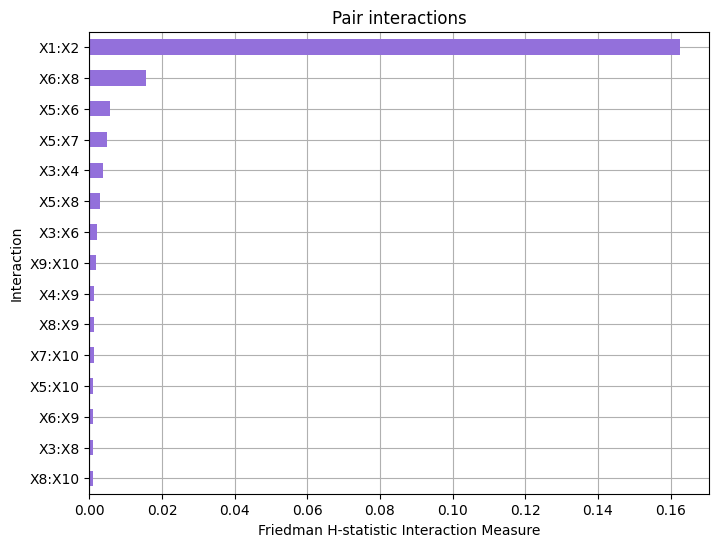

In [18]:
h_stat.plot("bar_chart", top_k = 15)

In [19]:
h_stat.ovo

,Feature 1,Feature 2,Friedman H-statistic Interaction Measure
0,X1,X2,0.162569
1,X6,X8,0.015588
2,X5,X6,0.005641
3,X5,X7,0.004730
4,X3,X4,0.003737
5,X5,X8,0.002893
6,X3,X6,0.002003
7,X9,X10,0.001856
8,X4,X9,0.001394
9,X8,X9,0.001311


Pierwsze 6 par zmiennych to rzeczywiście interakcje w danych. 

In [20]:
with open(results_path + "f2_hstat.pkl", "wb") as f:
    pickle.dump(h_stat, f)

In [21]:
h_stat.ovo.to_csv(results_path + "f2_hstat.csv")

In [22]:
ovo = h_stat.ovo.copy()
exp_mask = ovo.apply(lambda x: (x["Feature 1"], x["Feature 2"]) in expected_pairs, axis=1).cumsum()
res_hstat = [exp_mask[2], exp_mask[4], exp_mask[9], exp_mask[19]]
found_hstat = [el in list(zip(ovo.loc[:10, "Feature 1"], ovo.loc[:10, "Feature 2"])) for el in expected_pairs]

In [23]:
res_hstat

[3, 4, 7, 8]

### H statistic (unnormalized)

In [24]:
h_stat_unnormalized = FriedmanHStatisticMethod(normalized=False)
h_stat_unnormalized.fit(model, X_test, show_progress=True)

Calculating one vs all interactions: 100%|██████████| 10/10 [00:39<00:00,  3.94s/it]


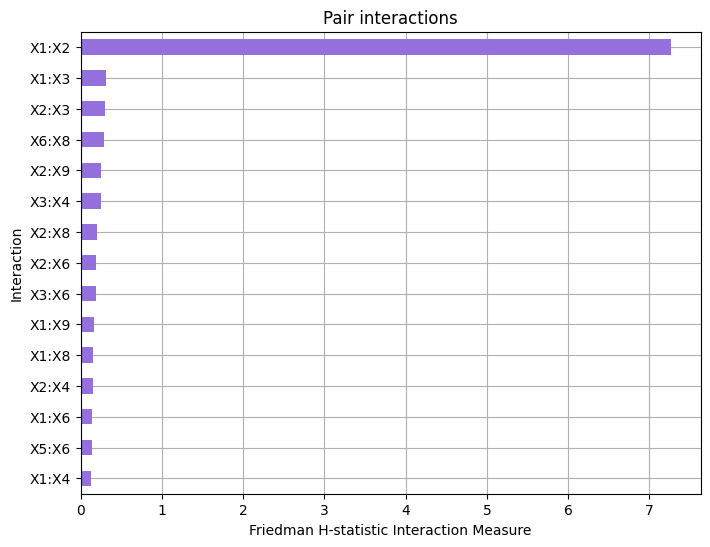

In [25]:
h_stat_unnormalized.plot("bar_chart", top_k=15)

In [26]:
h_stat_unnormalized.ovo

,Feature 1,Feature 2,Friedman H-statistic Interaction Measure
0,X1,X2,7.267656
1,X1,X3,0.317226
2,X2,X3,0.293637
3,X6,X8,0.283151
4,X2,X9,0.255477
5,X3,X4,0.244499
6,X2,X8,0.201918
7,X2,X6,0.193830
8,X3,X6,0.188247
9,X1,X9,0.165171


Pierwsze 6 par zmiennych to rzeczywiście interakcje w danych. 

In [27]:
with open(results_path + "f2_hstat_unnorm.pkl", "wb") as f:
    pickle.dump(h_stat_unnormalized, f)

In [28]:
h_stat_unnormalized.ovo.to_csv(results_path + "f2_hstat_unnorm.csv")

In [29]:
ovo = h_stat_unnormalized.ovo.copy()
exp_mask = ovo.apply(lambda x: (x["Feature 1"], x["Feature 2"]) in expected_pairs, axis=1).cumsum()
res_hstat_unnorm = [exp_mask[2], exp_mask[4], exp_mask[9], exp_mask[19]]
found_hstat_unnorm = [el in list(zip(ovo.loc[:10, "Feature 1"], ovo.loc[:10, "Feature 2"])) for el in expected_pairs]

In [30]:
res_hstat_unnorm

[1, 2, 3, 4]

### Sejong Oh Method

In [31]:
perf_based = SejongOhMethod()
perf_based.fit(model, X_test, y_test, show_progress=True)

Calculating feature importance: 100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


In [32]:
perf_based.ovo

,Feature 1,Feature 2,Sejong Oh Performance Based Interaction Measure
0,X1,X2,0.419633
1,X2,X3,0.100199
2,X1,X3,0.097882
3,X2,X6,0.050793
4,X1,X9,0.049203
5,X1,X4,0.045616
6,X2,X10,0.039763
7,X1,X7,0.037760
8,X2,X7,0.037483
9,X2,X8,0.034989


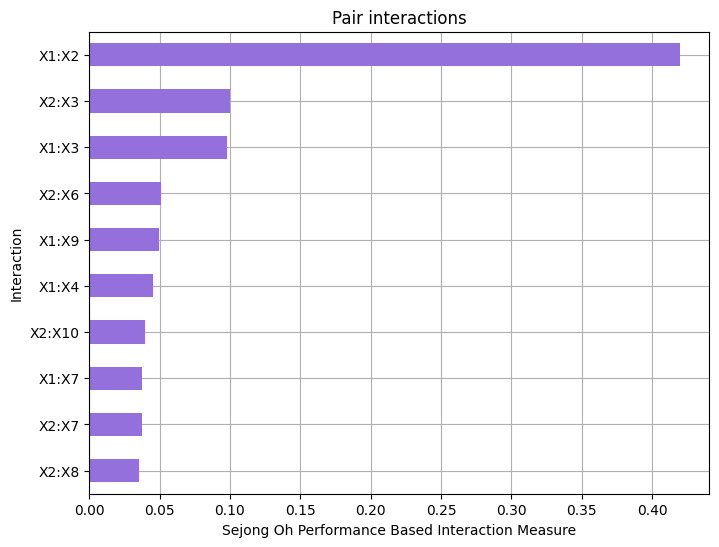

In [33]:
perf_based.plot("bar_chart", top_k=15)

In [34]:
perf_based.ovo

,Feature 1,Feature 2,Sejong Oh Performance Based Interaction Measure
0,X1,X2,0.419633
1,X2,X3,0.100199
2,X1,X3,0.097882
3,X2,X6,0.050793
4,X1,X9,0.049203
5,X1,X4,0.045616
6,X2,X10,0.039763
7,X1,X7,0.037760
8,X2,X7,0.037483
9,X2,X8,0.034989


Ta metoda działa najgorzej. Interakcja wskazana jako najwazniejsza nie jest zdefiniowana wprost w danych. 
Na dalszych pozycjach rowniez pojawia sie wiele nieoczekiwanych par zmiennych. 

In [35]:
with open(results_path + "f2_perf_based.pkl", "wb") as f:
    pickle.dump(perf_based, f)

In [36]:
perf_based.ovo.to_csv(results_path + "f2_per.csv")

In [37]:
ovo = perf_based.ovo.copy()
exp_mask = ovo.apply(lambda x: (x["Feature 1"], x["Feature 2"]) in expected_pairs, axis=1).cumsum()
res_perf = [exp_mask[2], exp_mask[4], exp_mask[9], exp_mask[19]]
found_perf = [el in list(zip(ovo.loc[:10, "Feature 1"], ovo.loc[:10, "Feature 2"])) for el in expected_pairs]

In [38]:
found = [["vint"] + found_vint, ["hstat"] + found_hstat, ["hstat_unnorm"] + found_hstat_unnorm, ["perf"] + found_perf]
which_found = pd.DataFrame(found, columns = ["method", "X1:X2", "X3:X4", "X5:X6", "X5:X8", "X6:X8", "X8:X9", "X8:X10", "X9:X10"])
res = [["vint"] + res_vint, ["hstat"] + res_hstat, ["hstat_unnorm"] + res_hstat_unnorm, ["perf_based"] + res_perf]
n_found = pd.DataFrame(res, columns = ["method", "top3", "top5", "top10", "top20"])
n_found.to_csv(results_path+"f2_n_found_reg.csv")
which_found.to_csv(results_path+"f2_which_found_reg.csv") 

### Klasyfikacja

In [39]:
def logit2prob(x):
    return np.exp(x)/(1+np.exp(x))

In [40]:
y_cls = np.random.binomial(1, logit2prob(y - y.mean()))

In [41]:
exp1_data = pd.DataFrame(np.hstack((X, y_cls.reshape(5000, 1))))
exp1_data.columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'y']
X = exp1_data.drop('y', axis=1)
y = exp1_data['y']
X_train, y_train = X.iloc[:4500], y.iloc[:4500]
X_test, y_test = X.iloc[4500:], y.iloc[4500:]

In [42]:
model = RandomForestClassifier(n_estimators=100, max_depth=10, max_features="sqrt").fit(X_train, y_train)

### Greenwell Method

In [43]:
import shap
X_test_repr = pd.DataFrame(shap.kmeans(X_test, 50).data, columns = X_test.columns)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [44]:
vint = GreenwellMethod()
vint.fit(model, X_test_repr, show_progress=True) 

Calculating feature importance: 100%|██████████| 10/10 [00:00<00:00, 17.03it/s]


In [45]:
vint.ovo

,Feature 1,Feature 2,Greenwell Variable Interaction Measure
0,X1,X2,0.065988
1,X2,X6,0.012222
2,X1,X6,0.008604
3,X3,X6,0.007071
4,X1,X3,0.006358
5,X2,X3,0.005917
6,X1,X9,0.005637
7,X2,X8,0.004718
8,X2,X7,0.004298
9,X2,X9,0.004020


In [46]:
with open(results_path + "f2_greenwell_cls.pkl", "wb") as f:
    pickle.dump(vint, f)

In [47]:
vint.ovo.to_csv(results_path + "f2_greenwell_cls.csv")

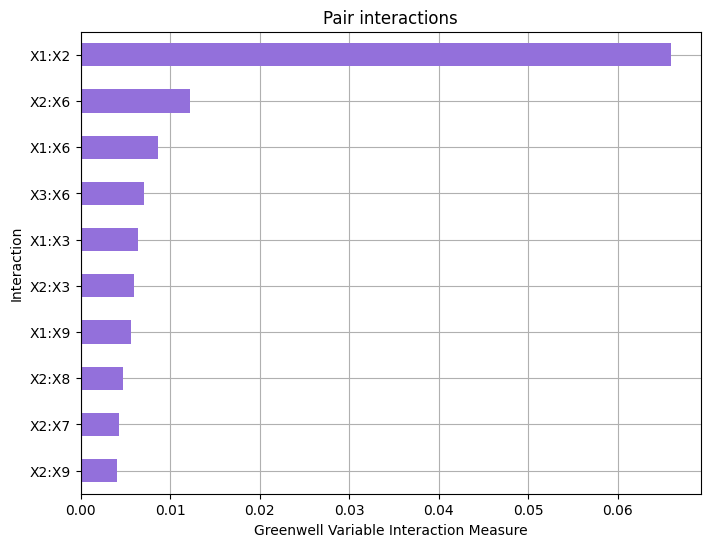

In [48]:
vint.plot("bar_chart", top_k=15)

In [49]:
ovo = vint.ovo.copy()
exp_mask = ovo.apply(lambda x: (x["Feature 1"], x["Feature 2"]) in expected_pairs, axis=1).cumsum()
res_vint_cls = [exp_mask[2], exp_mask[4], exp_mask[9], exp_mask[19]]
found_vint_cls= [el in list(zip(ovo.loc[:10, "Feature 1"], ovo.loc[:10, "Feature 2"])) for el in expected_pairs]

### H statistic (normalized)

In [50]:
h_stat = FriedmanHStatisticMethod()
h_stat.fit(model, X_test, show_progress=True)

Calculating one vs all interactions: 100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


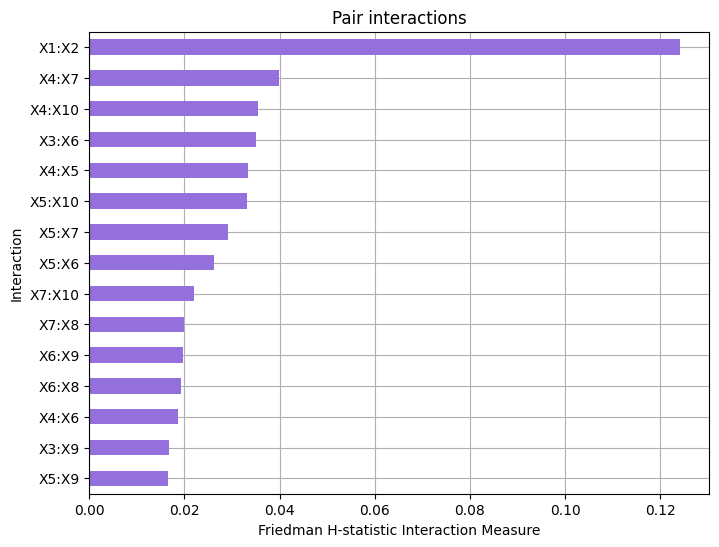

In [51]:
h_stat.plot("bar_chart", top_k = 15)

In [52]:
with open(results_path + "f2_hstat_cls.pkl", "wb") as f:
    pickle.dump(h_stat, f)

In [53]:
h_stat.ovo.to_csv(results_path + "f2_hstat_cls.csv")

In [54]:
ovo = h_stat.ovo.copy()
exp_mask = ovo.apply(lambda x: (x["Feature 1"], x["Feature 2"]) in expected_pairs, axis=1).cumsum()
res_hstat_cls = [exp_mask[2], exp_mask[4], exp_mask[9], exp_mask[19]]
found_hstat_cls= [el in list(zip(ovo.loc[:10, "Feature 1"], ovo.loc[:10, "Feature 2"])) for el in expected_pairs]

### H statistic (unnormalized)

In [55]:
h_stat_unnormalized = FriedmanHStatisticMethod(normalized=False)
h_stat_unnormalized.fit(model, X_test, show_progress=True)

Calculating one vs all interactions: 100%|██████████| 10/10 [00:46<00:00,  4.65s/it]


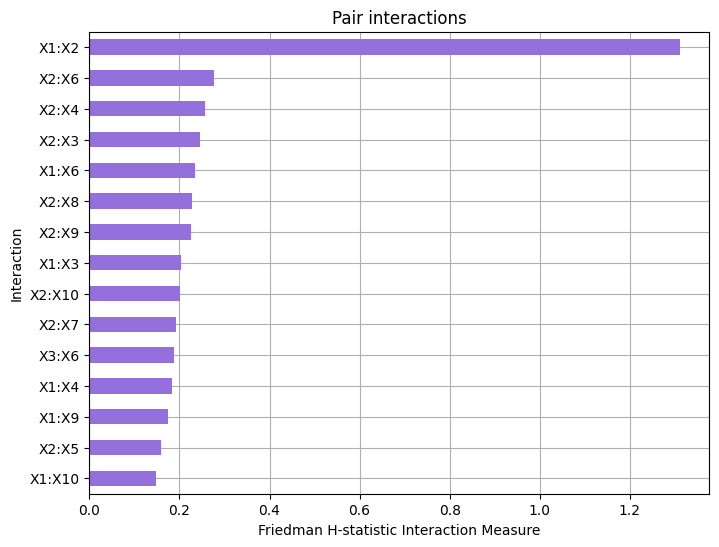

In [56]:
h_stat_unnormalized.plot("bar_chart", top_k=15)

In [57]:
h_stat_unnormalized.ovo

,Feature 1,Feature 2,Friedman H-statistic Interaction Measure
0,X1,X2,1.311257
1,X2,X6,0.275751
2,X2,X4,0.256131
3,X2,X3,0.244547
4,X1,X6,0.234974
5,X2,X8,0.227741
6,X2,X9,0.225927
7,X1,X3,0.204178
8,X2,X10,0.202061
9,X2,X7,0.192599


In [58]:
with open(results_path + "f2_hstat_unnormalized_cls.pkl", "wb") as f:
    pickle.dump(h_stat_unnormalized, f)

In [59]:
h_stat_unnormalized.ovo.to_csv(results_path + "f2_hstat_unnormalized_cls.csv")

In [60]:
ovo = h_stat_unnormalized.ovo.copy()
exp_mask = ovo.apply(lambda x: (x["Feature 1"], x["Feature 2"]) in expected_pairs, axis=1).cumsum()
res_hstat_unnorm_cls = [exp_mask[2], exp_mask[4], exp_mask[9], exp_mask[19]]
found_hstat_unnorm_cls= [el in list(zip(ovo.loc[:10, "Feature 1"], ovo.loc[:10, "Feature 2"])) for el in expected_pairs]

### Sejong Oh Method

In [61]:
perf_based = SejongOhMethod()
perf_based.fit(model, X_test, y_test, show_progress=True)

Calculating feature importance: 100%|██████████| 10/10 [00:01<00:00,  5.27it/s]


In [62]:
perf_based.ovo

,Feature 1,Feature 2,Sejong Oh Performance Based Interaction Measure
0,X1,X2,0.037707
1,X2,X9,0.022517
2,X2,X5,0.021778
3,X6,X7,0.021625
4,X2,X4,0.020887
5,X1,X9,0.020438
6,X1,X3,0.019795
7,X1,X8,0.019636
8,X1,X5,0.018959
9,X3,X6,0.018583


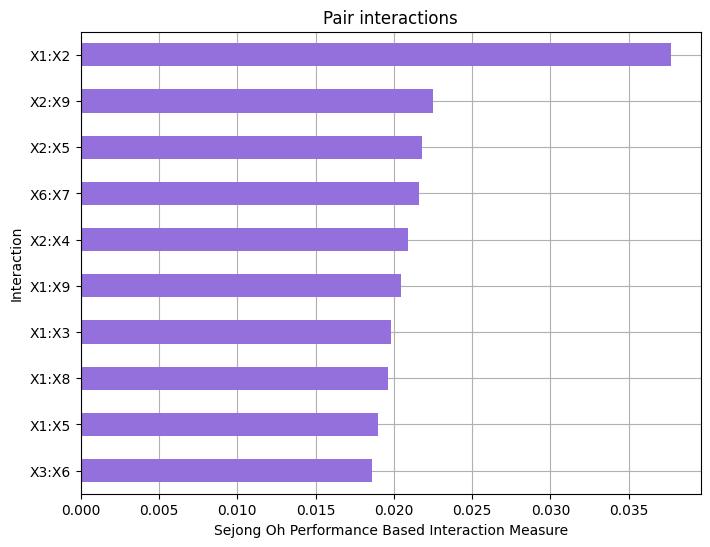

In [63]:
perf_based.plot("bar_chart", top_k=15)

In [64]:
with open(results_path + "f2_perf_based_cls.pkl", "wb") as f:
    pickle.dump(h_stat, f)

In [65]:
perf_based.ovo.to_csv(results_path + "f2_perf_cls.csv")

In [66]:
ovo = perf_based.ovo.copy()
exp_mask = ovo.apply(lambda x: (x["Feature 1"], x["Feature 2"]) in expected_pairs, axis=1).cumsum()
res_perf_cls = [exp_mask[2], exp_mask[4], exp_mask[9], exp_mask[19]]
found_perf_cls= [el in list(zip(ovo.loc[:10, "Feature 1"], ovo.loc[:10, "Feature 2"])) for el in expected_pairs]

In [67]:
found = [["vint"] + found_vint_cls, ["hstat"] + found_hstat_cls, ["hstat_unnorm"] + found_hstat_unnorm_cls, ["perf"] + found_perf_cls]
which_found = pd.DataFrame(found, columns = ["method", "X1:X2", "X3:X4", "X5:X6", "X5:X8", "X6:X8", "X8:X9", "X8:X10", "X9:X10"])
res = [["vint"] + res_vint_cls, ["hstat"] + res_hstat_cls, ["hstat_unnorm"] + res_hstat_unnorm_cls, ["perf_based"] + res_perf_cls]
n_found = pd.DataFrame(res, columns = ["method", "top3", "top5", "top10", "top20"])
n_found.to_csv(results_path+"f2_n_found_cls.csv")
which_found.to_csv(results_path+"f2_which_found_cls.csv") 

In [68]:
n_found

,method,top3,top5,top10,top20
0,vint,1,1,1,3
1,hstat,1,1,2,5
2,hstat_unnorm,1,1,1,2
3,perf_based,1,1,1,1


In [69]:
which_found

,method,X1:X2,X3:X4,X5:X6,X5:X8,X6:X8,X8:X9,X8:X10,X9:X10
0,vint,True,False,False,False,False,False,False,False
1,hstat,True,False,True,False,False,False,False,False
2,hstat_unnorm,True,False,False,False,False,False,False,False
3,perf,True,False,False,False,False,False,False,False
